# Temporal Effects

We lean on the `psifr` toolbox to generate three plots corresponding to the contents of Figure 4 in Morton & Polyn, 2016:
1. Recall probability as a function of serial position
2. Probability of starting recall with each serial position
3. Conditional response probability as a function of lag

Input data is presumed to be [formatted for use of the psifr toolbox](https://psifr.readthedocs.io/en/latest/guide/import.html). For demos, we'll import `psifr_sbs.csv`.

In [1]:
import pandas as pd
from psifr import fr

data = pd.read_csv('data/psifr_sbs.csv')
events = fr.merge_free_recall(data, list_keys=['item_index', 'cycle', 'story_index',
                                               'story_name', 'time_test'])

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,item_index,cycle,story_index,story_name,time_test
0,0,0,One fine day an old Maine man was fishing,1.0,NaN,True,False,0,False,0,0,0,Fisherman,1
1,0,0,on his favorite lake,2.0,2.0,True,True,0,False,1,0,0,Fisherman,1
2,0,0,and catching very little,3.0,NaN,True,False,0,False,2,0,0,Fisherman,1
3,0,0,"Finally, he gave up",4.0,3.0,True,True,0,False,3,1,0,Fisherman,1
4,0,0,and walked back along the shore to his fishing...,5.0,NaN,True,False,0,False,4,1,0,Fisherman,1


##  Serial Position Curves

`psifr` includes a lot of functions for visualization, but if your cookbook depends on them you'll get considerably less flexibility over the appearance and other features of your plots. I prefer to use the library to generate applicable DataFrames and then plot them myself.

In [2]:
from psifr import fr

fr.spc(events)

recall
subject input          
0       1.0    0.666667
        2.0    0.611111
        3.0    0.666667
        4.0    0.722222
        5.0    0.500000
...                 ...
21      39.0   0.333333
        40.0   0.333333
        41.0   0.000000
        42.0   0.666667
        43.0   0.000000

[946 rows x 1 columns]

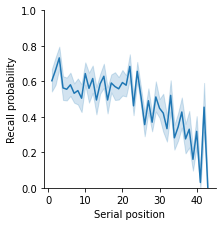

In [4]:
fr.plot_spc(fr.spc(events).reset_index())

What is the structure of this DataFrame? For each subject, the DataFrame tracks the rate at which items with each input position were recalled across all recorded trials. We can visualize these values aggregated across subject like so:

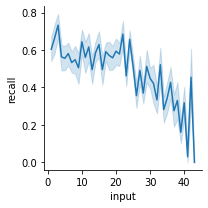

In [13]:
import seaborn as sns

g = sns.FacetGrid(fr.spc(events))
g.map_dataframe(sns.lineplot, 'input', 'recall');

### Story_Name Facets

But there are different numbers of idea units in different trials. The DataFrame retrieved when I call `fr.spc` doesn't include the `story_name` column indexing this factor, so I probably have to move beyond the provided library. Below we first pivot `events` to create a DataFrame like the output of `fr.spc`, but sorted by story name. Then we convert the tracked story names into a column of this DataFrame so that plots for each condition can be laid out on a FacetGrid.

In [64]:
clean = events.query('study').pivot_table(index=['story_name', 'input'], values=['recall'])
clean.reset_index(level=0, inplace=True)
clean

,story_name,recall
input,,
1.0,Beach,0.727273
2.0,Beach,0.833333
3.0,Beach,0.954545
4.0,Beach,0.484848
5.0,Beach,0.287879
...,...,...
35.0,Supermarket,0.212121
36.0,Supermarket,0.530303
37.0,Supermarket,0.530303


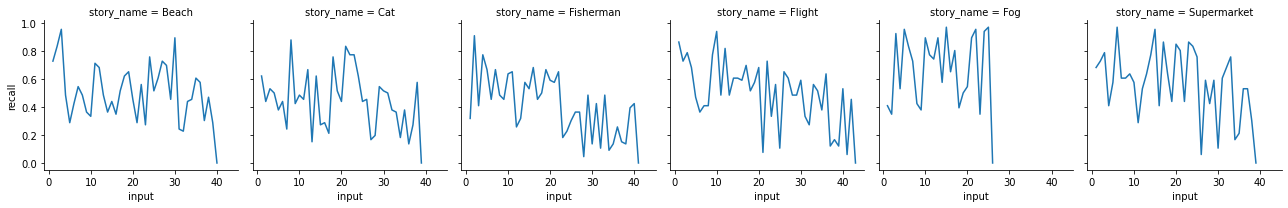

In [65]:
g = sns.FacetGrid(clean, col='story_name')
g.map_dataframe(sns.lineplot, 'input', 'recall');

### Subject-Level Curves

What if we wanted to visualize each subject's SPC for each story_name? To do this, we just have to aggregate over and then convert into a column another variable:

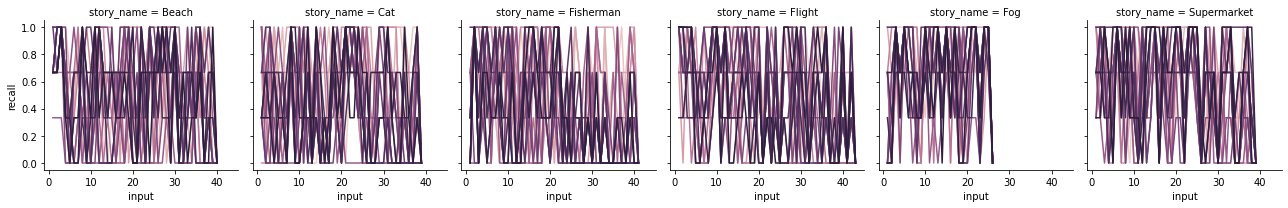

In [70]:
clean = events.query('study').pivot_table(index=['subject', 'story_name', 'input'], values=['recall'])
clean.reset_index(level=0, inplace=True)
clean.reset_index(level=0, inplace=True)

g = sns.FacetGrid(clean, col='story_name')
g.map_dataframe(sns.lineplot, 'input', 'recall', hue='subject');

And then we could view aggregated SPCs by each subject facet instead of story_name:

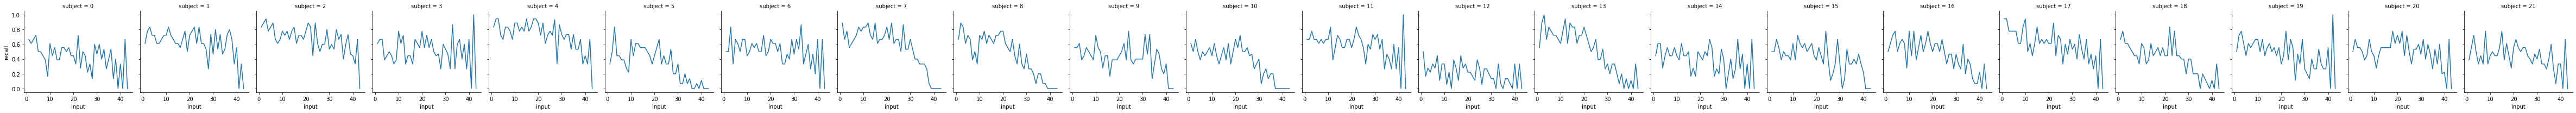

In [72]:
clean = events.query('study').pivot_table(index=['subject', 'input'], values=['recall'])
clean.reset_index(level=0, inplace=True)

g = sns.FacetGrid(clean, col='subject')
g.map_dataframe(sns.lineplot, 'input', 'recall');

### Automatic Confidence Intervals

Seaborn's `lineplot` function also automatically computes confidence intervals over any additional factors you include. For example, it might be possible to include a `list` column in our calculations if we want to see something like a 95% confidence interval over each trial in our facet. The original `fr.spc` shows a confidence interval over subject, so we do that here:

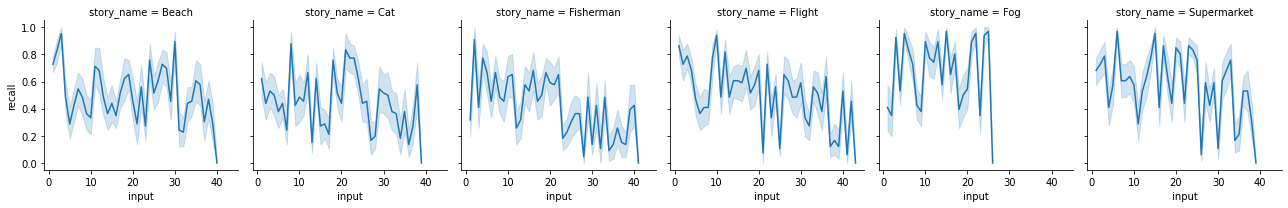

In [77]:
clean = events.query('study').pivot_table(index=['subject', 'story_name', 'input'], values=['recall'])
clean.reset_index(inplace=True)

g = sns.FacetGrid(clean, col='story_name')
g.map_dataframe(sns.lineplot, 'input', 'recall');

What have we learned? Dataframes useful for visualizing a serial position curve are easy enough to generate that resorting to `psifr` to do it is often unnecessary. When you'll want to generate serial position curves over different conditions in your dataset, it's often worth it. Applying `pivot_table` with your condition as one of the indices and then applying `reset_index` to convert your indices into columns creates a DataFrame you can easily generate these visualizations over.

## Lag CRPs
Because serial position curves amount to a mean over values in one column split between each condition in a different column, generating them is well-supported by pandas and seaborn. But what about more domain-specific analyses like our lag CRP?

Again, `psifr` includes a function tracking these statistics out of the box:

In [78]:
fr.lag_crp(events)

prob  actual  possible
subject lag                          
0       -42.0   NaN       0         0
        -41.0   NaN       0         0
        -40.0   NaN       0         0
        -39.0   NaN       0         0
        -38.0   0.0       0         1
...             ...     ...       ...
21       38.0   0.0       0        21
         39.0   0.0       0        17
         40.0   0.0       0         9
         41.0   0.0       0         6
         42.0   0.0       0         3

[1870 rows x 3 columns]

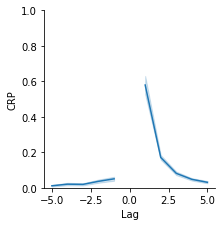

In [84]:
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

g = sns.FacetGrid(fr.lag_crp(events).reset_index())
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_neg), x='lag', y='prob', **kws)
)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_pos), x='lag', y='prob', **kws)
)
g.set_xlabels('Lag')
g.set_ylabels('CRP')
g.set(ylim=(0, 1));

A 95% confidence interval is plotted over each subject just like with our basic SPC.

### Story_Name Facets

We similarly want to be able to see a corresponding plot for each story_name. But it obviously will take more work to get there. Instead of trying to replace `psifr.lag_crp` with an in-house implementation, we'll just apply it for different parts of our dataset and then aggregate the resulting DataFrame. This is also an option for using psifr to generate SPCs if we're not interested in writing our own code that tracks each factor:

In [136]:
lag_crps = []
for story_name in pd.unique(events.story_name):
    lag_crps.append(fr.lag_crp(events[events.story_name == story_name]))
    
clean = pd.concat(lag_crps, keys=pd.unique(events.story_name), names=['story_name']).reset_index()
clean

,story_name,subject,lag,prob,actual,possible
0,Fisherman,0,-40.0,NaN,0,0
1,Fisherman,0,-39.0,NaN,0,0
2,Fisherman,0,-38.0,NaN,0,0
3,Fisherman,0,-37.0,NaN,0,0
4,Fisherman,0,-36.0,0.0,0,1
...,...,...,...,...,...,...
9895,Beach,21,35.0,0.0,0,8
9896,Beach,21,36.0,0.0,0,8
9897,Beach,21,37.0,0.0,0,7
9898,Beach,21,38.0,0.0,0,4


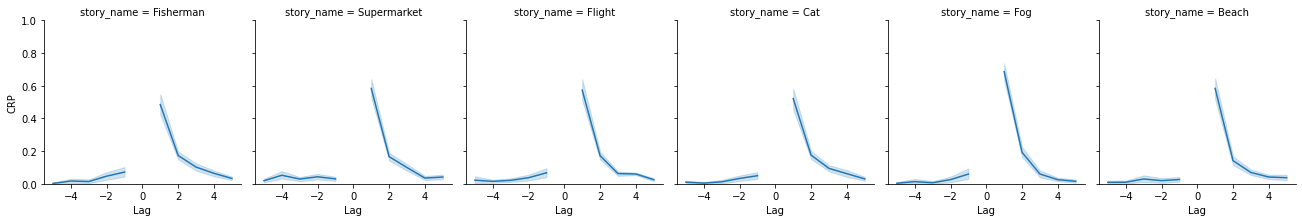

In [137]:
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

g = sns.FacetGrid(clean, col='story_name')
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_neg), x='lag', y='prob', **kws)
)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_pos), x='lag', y='prob', **kws)
)
g.set_xlabels('Lag')
g.set_ylabels('CRP')
g.set(ylim=(0, 1));

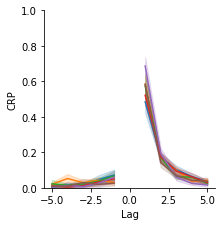

In [142]:
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

g = sns.FacetGrid(clean)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_neg), x='lag', y='prob', hue='story_name', **kws)
)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_pos), x='lag', y='prob', hue='story_name', **kws)
)
g.set_xlabels('Lag')
g.set_ylabels('CRP')
g.set(ylim=(0, 1));

This approach gives us the full dataframe we're interested in, giving us room to customize plotting outputs ourselves. 

## Lag Rank
As explained in the psifr documentation:

> We can summarize the tendency to group together nearby items using a lag rank analysis. For each recall, this determines the absolute lag of all remaining items available for recall and then calculates their percentile rank. Then the rank of the actual transition made is taken, scaled to vary between 0 (furthest item chosen) and 1 (nearest item chosen). Chance clustering will be 0.5; clustering above that value is evidence of a temporal contiguity effect.

In [94]:
fr.lag_rank(events)

,rank
subject,
0,0.911810
1,0.966727
2,0.959053
3,0.934698
4,0.975818
5,0.925472
6,0.934625
7,0.961517
8,0.953671


### T-Testing
Papers using this metric have applied one-sample t-tests over each subject to test the null hypothesis that no clustering is happening on the basis of chance (mean = .5). Since .5 is the floor output for this analysis, we're doing a one-tailed analysis.

In [98]:
from scipy import stats

stats.ttest_1samp(fr.lag_rank(events), .5, alternative='greater')

Ttest_1sampResult(statistic=array([66.98674719]), pvalue=array([2.83010415e-26]))

### Story_Name Facets

An approach similar to our handling of CRPs across facets is okay:

In [100]:
lag_ranks = []
for story_name in pd.unique(events.story_name):
    lag_ranks.append(fr.lag_rank(events[events.story_name == story_name]))
    
clean = pd.concat(lag_ranks, keys=pd.unique(events.story_name), names=['story_name']).reset_index()
clean

,story_name,subject,rank
0,Fisherman,0,0.891909
1,Fisherman,1,0.956202
2,Fisherman,2,0.925599
3,Fisherman,3,0.923167
4,Fisherman,4,0.974875
...,...,...,...
127,Beach,17,0.963376
128,Beach,18,0.925565
129,Beach,19,0.936923
130,Beach,20,0.945689


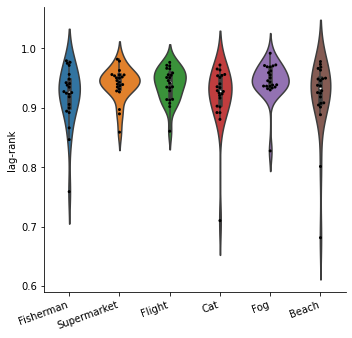

In [134]:
import matplotlib.pyplot as plt

g = sns.catplot(x='story_name', y='rank', data=clean, kind='violin');
sns.swarmplot(x='story_name', y='rank', data=clean, ax=g.ax, color="k", size=3);

g.set_xticklabels(rotation=20, ha="right")
plt.tight_layout()
plt.xlabel('')
plt.ylabel('lag-rank')
plt.show()

The exact plot I want depends so much on the context that I'll just use the psifr library to help generate DataFrames and transform from there.

# Temporal Effects

We lean on the `psifr` toolbox to generate three plots corresponding to the contents of Figure 4 in Morton & Polyn, 2016:
1. Recall probability as a function of serial position
2. Probability of starting recall with each serial position
3. Conditional response probability as a function of lag

Input data is presumed to be [formatted for use of the psifr toolbox](https://psifr.readthedocs.io/en/latest/guide/import.html). For demos, we'll import `psifr_sbs.csv`.

In [ ]:
import pandas as pd
from psifr import fr

data = pd.read_csv('data/psifr_sbs.csv')
events = fr.merge_free_recall(data, list_keys=['item_index', 'cycle', 'story_index',
                                               'story_name', 'time_test'])

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,item_index,cycle,story_index,story_name,time_test
0,0,0,One fine day an old Maine man was fishing,1.0,NaN,True,False,0,False,0,0,0,Fisherman,1
1,0,0,on his favorite lake,2.0,2.0,True,True,0,False,1,0,0,Fisherman,1
2,0,0,and catching very little,3.0,NaN,True,False,0,False,2,0,0,Fisherman,1
3,0,0,"Finally, he gave up",4.0,3.0,True,True,0,False,3,1,0,Fisherman,1
4,0,0,and walked back along the shore to his fishing...,5.0,NaN,True,False,0,False,4,1,0,Fisherman,1


##  Serial Position Curves

`psifr` includes a lot of functions for visualization, but if your cookbook depends on them you'll get considerably less flexibility over the appearance and other features of your plots. I prefer to use the library to generate applicable DataFrames and then plot them myself.

In [ ]:
from psifr import fr

fr.spc(events)

recall
subject input          
0       1.0    0.666667
        2.0    0.611111
        3.0    0.666667
        4.0    0.722222
        5.0    0.500000
...                 ...
21      39.0   0.333333
        40.0   0.333333
        41.0   0.000000
        42.0   0.666667
        43.0   0.000000

[946 rows x 1 columns]

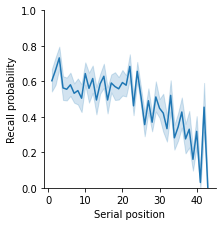

In [ ]:
fr.plot_spc(fr.spc(events).reset_index())

What is the structure of this DataFrame? For each subject, the DataFrame tracks the rate at which items with each input position were recalled across all recorded trials. We can visualize these values aggregated across subject like so:

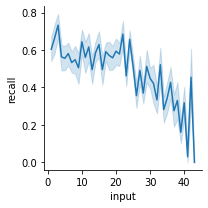

In [ ]:
import seaborn as sns

g = sns.FacetGrid(fr.spc(events))
g.map_dataframe(sns.lineplot, 'input', 'recall');

### Story_Name Facets

But there are different numbers of idea units in different trials. The DataFrame retrieved when I call `fr.spc` doesn't include the `story_name` column indexing this factor, so I probably have to move beyond the provided library. Below we first pivot `events` to create a DataFrame like the output of `fr.spc`, but sorted by story name. Then we convert the tracked story names into a column of this DataFrame so that plots for each condition can be laid out on a FacetGrid.

In [ ]:
clean = events.query('study').pivot_table(index=['story_name', 'input'], values=['recall'])
clean.reset_index(level=0, inplace=True)
clean

,story_name,recall
input,,
1.0,Beach,0.727273
2.0,Beach,0.833333
3.0,Beach,0.954545
4.0,Beach,0.484848
5.0,Beach,0.287879
...,...,...
35.0,Supermarket,0.212121
36.0,Supermarket,0.530303
37.0,Supermarket,0.530303


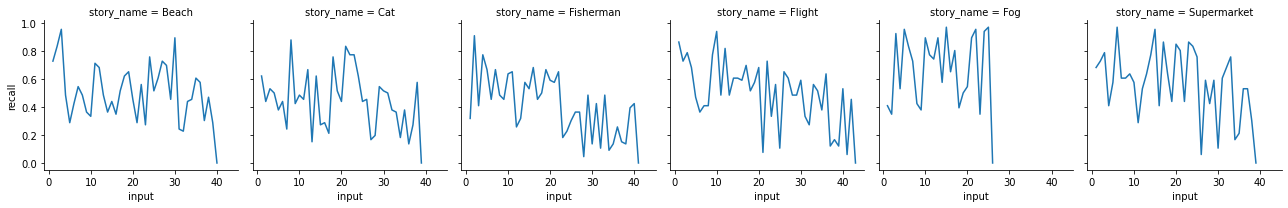

In [ ]:
g = sns.FacetGrid(clean, col='story_name')
g.map_dataframe(sns.lineplot, 'input', 'recall');

### Subject-Level Curves

What if we wanted to visualize each subject's SPC for each story_name? To do this, we just have to aggregate over and then convert into a column another variable:

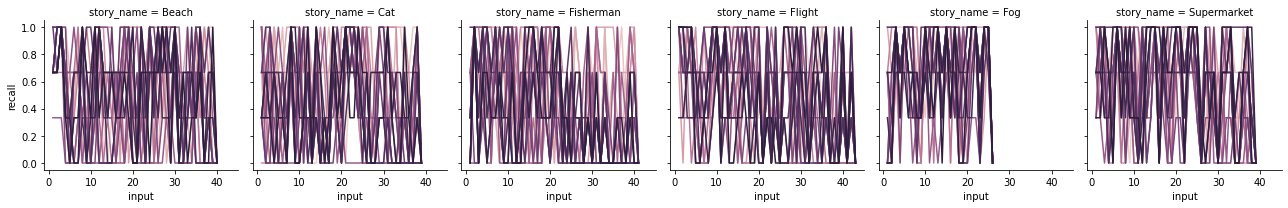

In [ ]:
clean = events.query('study').pivot_table(index=['subject', 'story_name', 'input'], values=['recall'])
clean.reset_index(level=0, inplace=True)
clean.reset_index(level=0, inplace=True)

g = sns.FacetGrid(clean, col='story_name')
g.map_dataframe(sns.lineplot, 'input', 'recall', hue='subject');

And then we could view aggregated SPCs by each subject facet instead of story_name:

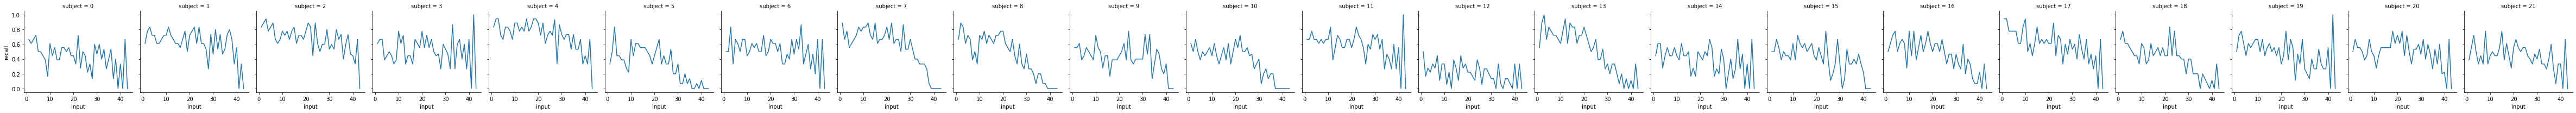

In [ ]:
clean = events.query('study').pivot_table(index=['subject', 'input'], values=['recall'])
clean.reset_index(level=0, inplace=True)

g = sns.FacetGrid(clean, col='subject')
g.map_dataframe(sns.lineplot, 'input', 'recall');

### Automatic Confidence Intervals

Seaborn's `lineplot` function also automatically computes confidence intervals over any additional factors you include. For example, it might be possible to include a `list` column in our calculations if we want to see something like a 95% confidence interval over each trial in our facet. The original `fr.spc` shows a confidence interval over subject, so we do that here:

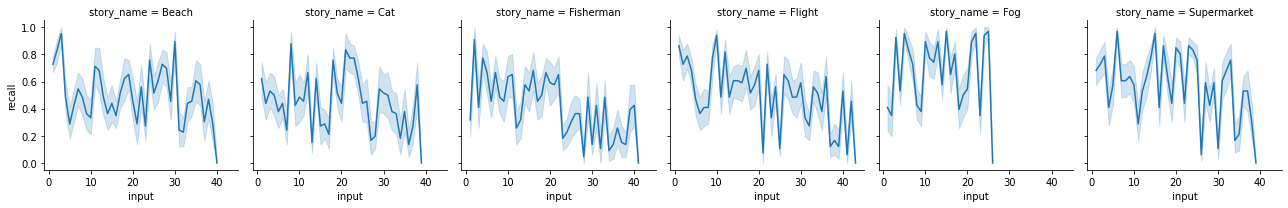

In [ ]:
clean = events.query('study').pivot_table(index=['subject', 'story_name', 'input'], values=['recall'])
clean.reset_index(inplace=True)

g = sns.FacetGrid(clean, col='story_name')
g.map_dataframe(sns.lineplot, 'input', 'recall');

What have we learned? Dataframes useful for visualizing a serial position curve are easy enough to generate that resorting to `psifr` to do it is often unnecessary. When you'll want to generate serial position curves over different conditions in your dataset, it's often worth it. Applying `pivot_table` with your condition as one of the indices and then applying `reset_index` to convert your indices into columns creates a DataFrame you can easily generate these visualizations over.

## Lag CRPs
Because serial position curves amount to a mean over values in one column split between each condition in a different column, generating them is well-supported by pandas and seaborn. But what about more domain-specific analyses like our lag CRP?

Again, `psifr` includes a function tracking these statistics out of the box:

In [ ]:
fr.lag_crp(events)

prob  actual  possible
subject lag                          
0       -42.0   NaN       0         0
        -41.0   NaN       0         0
        -40.0   NaN       0         0
        -39.0   NaN       0         0
        -38.0   0.0       0         1
...             ...     ...       ...
21       38.0   0.0       0        21
         39.0   0.0       0        17
         40.0   0.0       0         9
         41.0   0.0       0         6
         42.0   0.0       0         3

[1870 rows x 3 columns]

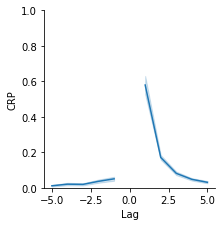

In [ ]:
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

g = sns.FacetGrid(fr.lag_crp(events).reset_index())
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_neg), x='lag', y='prob', **kws)
)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_pos), x='lag', y='prob', **kws)
)
g.set_xlabels('Lag')
g.set_ylabels('CRP')
g.set(ylim=(0, 1));

A 95% confidence interval is plotted over each subject just like with our basic SPC.

### Story_Name Facets

We similarly want to be able to see a corresponding plot for each story_name. But it obviously will take more work to get there. Instead of trying to replace `psifr.lag_crp` with an in-house implementation, we'll just apply it for different parts of our dataset and then aggregate the resulting DataFrame. This is also an option for using psifr to generate SPCs if we're not interested in writing our own code that tracks each factor:

In [ ]:
lag_crps = []
for story_name in pd.unique(events.story_name):
    lag_crps.append(fr.lag_crp(events[events.story_name == story_name]))
    
clean = pd.concat(lag_crps, keys=pd.unique(events.story_name), names=['story_name']).reset_index()
clean

,story_name,subject,lag,prob,actual,possible
0,Fisherman,0,-40.0,NaN,0,0
1,Fisherman,0,-39.0,NaN,0,0
2,Fisherman,0,-38.0,NaN,0,0
3,Fisherman,0,-37.0,NaN,0,0
4,Fisherman,0,-36.0,0.0,0,1
...,...,...,...,...,...,...
9895,Beach,21,35.0,0.0,0,8
9896,Beach,21,36.0,0.0,0,8
9897,Beach,21,37.0,0.0,0,7
9898,Beach,21,38.0,0.0,0,4


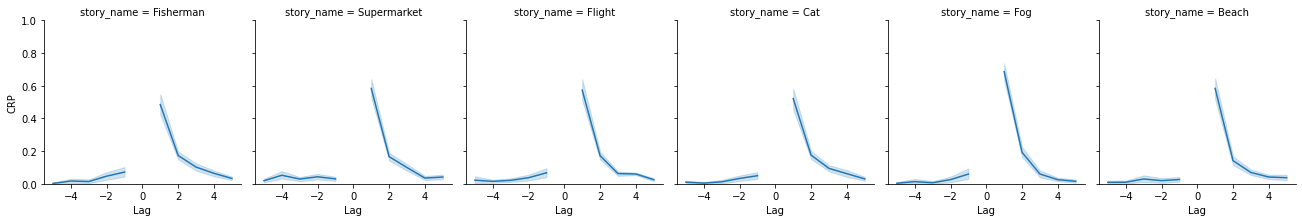

In [ ]:
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

g = sns.FacetGrid(clean, col='story_name')
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_neg), x='lag', y='prob', **kws)
)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_pos), x='lag', y='prob', **kws)
)
g.set_xlabels('Lag')
g.set_ylabels('CRP')
g.set(ylim=(0, 1));

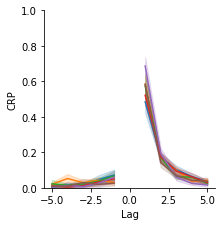

In [ ]:
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

g = sns.FacetGrid(clean)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_neg), x='lag', y='prob', hue='story_name', **kws)
)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_pos), x='lag', y='prob', hue='story_name', **kws)
)
g.set_xlabels('Lag')
g.set_ylabels('CRP')
g.set(ylim=(0, 1));

This approach gives us the full dataframe we're interested in, giving us room to customize plotting outputs ourselves. 

## Lag Rank
As explained in the psifr documentation:

> We can summarize the tendency to group together nearby items using a lag rank analysis. For each recall, this determines the absolute lag of all remaining items available for recall and then calculates their percentile rank. Then the rank of the actual transition made is taken, scaled to vary between 0 (furthest item chosen) and 1 (nearest item chosen). Chance clustering will be 0.5; clustering above that value is evidence of a temporal contiguity effect.

In [ ]:
fr.lag_rank(events)

,rank
subject,
0,0.911810
1,0.966727
2,0.959053
3,0.934698
4,0.975818
5,0.925472
6,0.934625
7,0.961517
8,0.953671


### T-Testing
Papers using this metric have applied one-sample t-tests over each subject to test the null hypothesis that no clustering is happening on the basis of chance (mean = .5). Since .5 is the floor output for this analysis, we're doing a one-tailed analysis.

In [ ]:
from scipy import stats

stats.ttest_1samp(fr.lag_rank(events), .5, alternative='greater')

Ttest_1sampResult(statistic=array([66.98674719]), pvalue=array([2.83010415e-26]))

### Story_Name Facets

An approach similar to our handling of CRPs across facets is okay:

In [ ]:
lag_ranks = []
for story_name in pd.unique(events.story_name):
    lag_ranks.append(fr.lag_rank(events[events.story_name == story_name]))
    
clean = pd.concat(lag_ranks, keys=pd.unique(events.story_name), names=['story_name']).reset_index()
clean

,story_name,subject,rank
0,Fisherman,0,0.891909
1,Fisherman,1,0.956202
2,Fisherman,2,0.925599
3,Fisherman,3,0.923167
4,Fisherman,4,0.974875
...,...,...,...
127,Beach,17,0.963376
128,Beach,18,0.925565
129,Beach,19,0.936923
130,Beach,20,0.945689


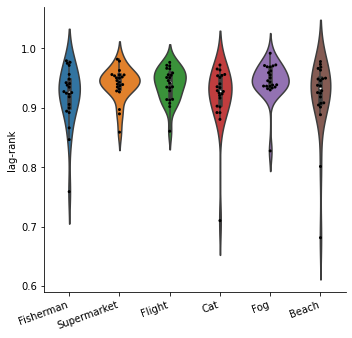

In [ ]:
import matplotlib.pyplot as plt

g = sns.catplot(x='story_name', y='rank', data=clean, kind='violin');
sns.swarmplot(x='story_name', y='rank', data=clean, ax=g.ax, color="k", size=3);

g.set_xticklabels(rotation=20, ha="right")
plt.tight_layout()
plt.xlabel('')
plt.ylabel('lag-rank')
plt.show()

The exact plot I want depends so much on the context that I'll just use the psifr library to help generate DataFrames and transform from there.